# ERA5-Land Urban heat Analysis over Mumbai

In [1]:
pip install cmcrameri bioblend

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pprint import pprint

import bioblend.galaxy
import os
import glob

import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import datetime
from textwrap import wrap

## Connect to Galaxy History to download datasets locally

In [3]:
api_key = os.getenv('API_KEY', default=None)
server = 'https://usegalaxy.eu/'
gi = bioblend.galaxy.GalaxyInstance(url=server, key=api_key)

In [6]:
hist = gi.histories.get_histories(name='ERA5-Land Mumbai')

In [7]:
hist_id  = hist[0]['id']

In [8]:
hist_id

'f8874274edf82b39'

In [9]:
history_datasets_info = gi.histories.show_history(history_id=hist_id, contents=True)

In [10]:
def search(list, name):
    for i in range(len(list)):
        if list[i] == name:
            return True
    return False

In [11]:
dataset_name = 'Copernicus Climate Data Store'
dataset_extension = 'netcdf'
for ds in history_datasets_info:
    print (ds['name'])
    hourly_tag = search(ds['tags'], 'name:hourly')
    #print (hourly_tag, ds['extension'])
    if ds['name'] == dataset_name and ds['extension'] == dataset_extension and hourly_tag:
        # download dataset
        print (ds['name'], ds['tags'])
        dsname = "dataset"
        for tag in ds['tags']:
            dsname = dsname + tag.replace('name:', '_')
        dsname = dsname + '.' + ds['extension']
        datasets = gi.datasets.download_dataset(ds['id'],
                                            file_path='./data/'+ dsname,
                                            use_default_filename=False,
                                            maxwait=5)
        print('Downloaded ', dsname)

Copernicus Climate Data Store
Copernicus Climate Data Store
Copernicus Climate Data Store
Copernicus Climate Data Store
Copernicus Climate Data Store
Copernicus Climate Data Store
Copernicus Climate Data Store ['name:1950-1959', 'name:hourly', 'name:reanalysis-era5-land']
Downloaded  dataset_1950-1959_hourly_reanalysis-era5-land.netcdf
Copernicus Climate Data Store
Copernicus Climate Data Store
Copernicus Climate Data Store ['name:1960-1969', 'name:hourly', 'name:reanalysis-era5-land']
Downloaded  dataset_1960-1969_hourly_reanalysis-era5-land.netcdf
Executed Pangeo Notebook
Copernicus Climate Data Store
Copernicus Climate Data Store
Copernicus Climate Data Store ['name:1970-1979', 'name:hourly', 'name:reanalysis-era5-land']
Downloaded  dataset_1970-1979_hourly_reanalysis-era5-land.netcdf
Copernicus Climate Data Store
Copernicus Climate Data Store
Copernicus Climate Data Store ['name:1980-1989', 'name:hourly', 'name:reanalysis-era5-land']
Downloaded  dataset_1980-1989_hourly_reanalysis-

## Open datasets with xarray

In [12]:
lfiles = glob.glob('./data/*.netcdf')
lfiles.sort()
lfiles

['./data/dataset_1950-1959_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_1960-1969_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_1970-1979_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_1980-1989_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_1990-1999_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_2000-2009_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_2010-2020_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_2021_hourly_reanalysis-era5-land.netcdf']

In [13]:
dset = xr.open_mfdataset(lfiles)
dset

<xarray.Dataset>
Dimensions:    (longitude: 6, latitude: 6, time: 631151)
Coordinates:
  * longitude  (longitude) float32 72.5 72.6 72.7 72.8 72.9 73.0
  * latitude   (latitude) float32 19.25 19.15 19.05 18.95 18.85 18.75
  * time       (time) datetime64[ns] 1950-01-01T01:00:00 ... 2021-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(87647, 6, 6), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-27 02:49:28 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Daily min and max temperatures

In [14]:
# Daily min and max
Tmax = dset['t2m'].resample(time='D').max()
Tmin = dset['t2m'].resample(time='D').min()

## Yearly mean of Tmin and Tmax

In [15]:
# Yearly averages
Tmax_Y = Tmax.resample(time='Y').mean()
Tmin_Y = Tmin.resample(time='Y').mean()
Tmax_Y

<xarray.DataArray 't2m' (time: 72, latitude: 6, longitude: 6)>
dask.array<stack, shape=(72, 6, 6), dtype=float32, chunksize=(1, 6, 6), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1950-12-31 1951-12-31 ... 2021-12-31
  * longitude  (longitude) float32 72.5 72.6 72.7 72.8 72.9 73.0
  * latitude   (latitude) float32 19.25 19.15 19.05 18.95 18.85 18.75

## Select one single point over Mumbai

In [16]:
# Selection of points near 19.25N,73.0E
Tmax_Yavs = Tmax_Y.sel(latitude='19.25', longitude='73.0', method= "nearest")
Tmin_Yavs = Tmin_Y.sel(latitude='19.25', longitude='73.0', method= "nearest")
Tmin_Yavs

<xarray.DataArray 't2m' (time: 72)>
dask.array<getitem, shape=(72,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1950-12-31 1951-12-31 ... 2021-12-31
    longitude  float32 73.0
    latitude   float32 19.25

## Convert Temperature from Kelvin to degrees Celcius

In [17]:
# Conversion to ° Celcius
Tmax_YavsC = Tmax_Yavs - 273.15 
Tmin_YavsC = Tmin_Yavs - 273.15 
print('Tmax ', Tmax_YavsC.min().values, Tmax_YavsC.max().values)
print('Tmin ', Tmin_YavsC.min().values, Tmin_YavsC.max().values)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Tmax  29.451813 32.15088


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Tmin  21.29242 23.213379


## Visualize Tmin and Tmax

### Minimum Temperature over Mumbai

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


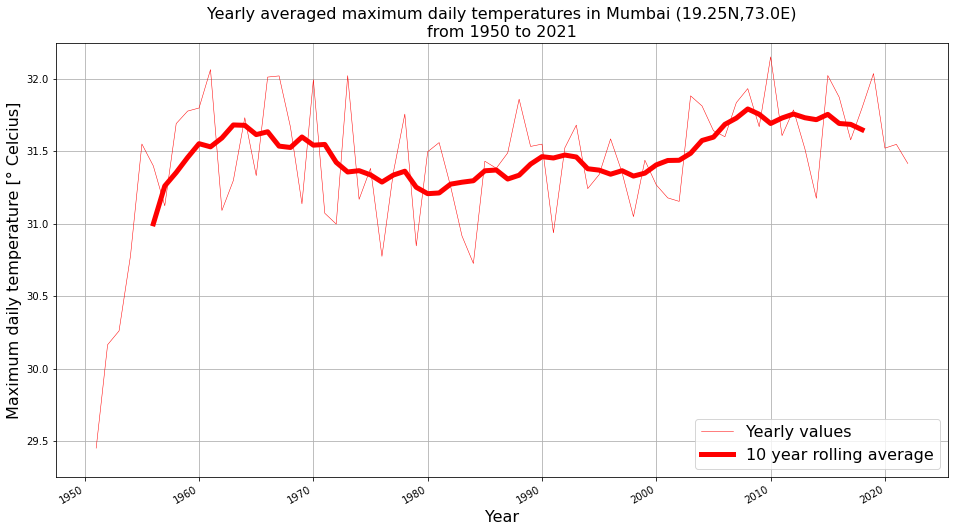

In [18]:
fig = plt.figure(figsize=[16,8])
ax = plt.subplot(1, 1, 1)
Tmax_YavsC.plot(ax=ax, label='Yearly values', color="red", linewidth=0.5)
Tmax_YavsC.rolling(time=10, center=True).mean().plot(ax=ax, label='10 year rolling average', color="red", linewidth=5)
ax.set_ylim(29.25, 32.25)
ax.set_title("\n".join(wrap('Yearly averaged maximum daily temperatures in Mumbai (19.25N,73.0E) from 1950 to 2021')), fontsize=16)
ax.set_ylabel("\n".join(wrap('Maximum daily temperature [° Celcius]')), fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.legend(fontsize=16)
ax.grid()

### Maximum Temperature over Mumbai

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


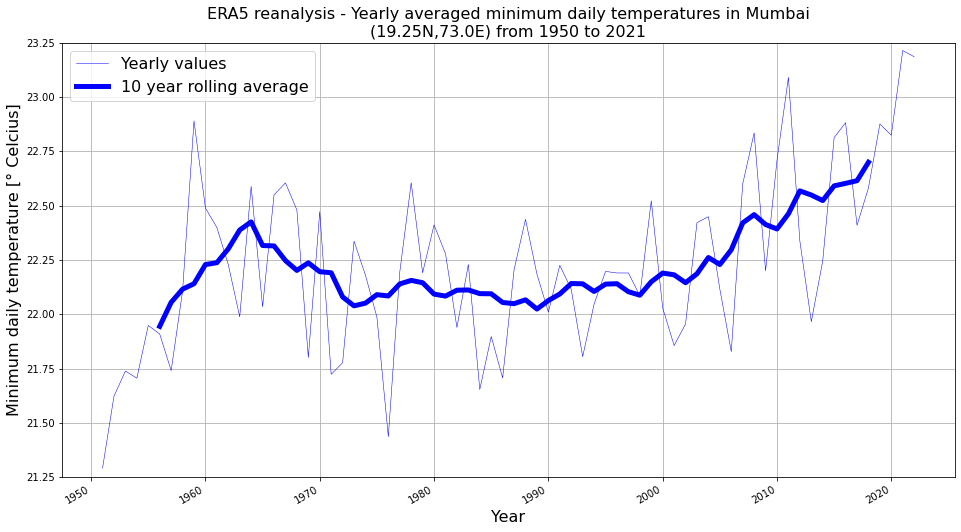

In [19]:
fig = plt.figure(figsize=[16,8])
ax = plt.subplot(1, 1, 1)
Tmin_YavsC.plot(ax=ax, label='Yearly values', color="blue", linewidth=0.5)
Tmin_YavsC.rolling(time=10, center=True).mean().plot(ax=ax, label='10 year rolling average', color="blue", linewidth=5)
ax.set_ylim(21.25, 23.25)
ax.set_title("\n".join(wrap('ERA5 reanalysis - Yearly averaged minimum daily temperatures in Mumbai (19.25N,73.0E) from 1950 to 2021')), fontsize=16)
ax.set_ylabel("\n".join(wrap('Minimum daily temperature [° Celcius]')), fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.legend(fontsize=16)
ax.grid()